In [83]:
from math import ceil
from pathlib import Path
import pandas as pd
from fastai.vision import *
from efficientnet_pytorch import EfficientNet

## Train on Random split train / val set

#### validate transform

In [84]:
def get_ex(): return open_image('/data2/datasets/clobotics/ccth/images/cropped/versions/train20200129_val20200117_test20191122/for-image-quality-model/round1/lose_discriminative_feature/1037554/27cb83e5c89ee857a864aee8beac0ca2_9_1037554.jpg')
# def get_ex(): return open_image('/data2/datasets/clobotics/ccth/images/cropped/versions/train20200129_val20200117_test20191122/for-image-quality-model/round1/good/1037551/8c0aae77071a17c419f6dc8f01968259_47_1037551.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width, height))[1].flatten())]

In [85]:
# tfms = get_transforms()
tfms = get_transforms(
    do_flip=True,  # default True
    flip_vert=False,  # default False
    max_rotate=10.0,  # default 10.0
    max_zoom=1.1,  # default 1.1
    max_lighting=0.2,  # default 0.2
    max_warp=0.2,  # default 0.2
    p_affine=0.75,  # default 0.75
    p_lighting=0.75,  # default 0.75
)

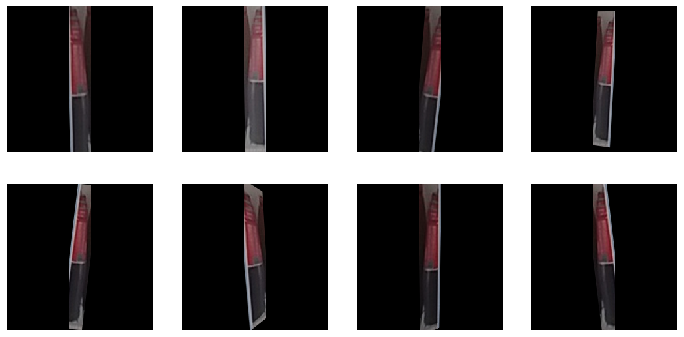

In [87]:
plots_f(2, 4, 12, 6, size=224, resize_method=ResizeMethod.PAD, padding_mode='zeros')

### Data

In [170]:
tfms = get_transforms(
    do_flip=True,  # default True
    flip_vert=False,  # default False
    max_rotate=5.0,  # default 10.0
    max_zoom=1.1,  # default 1.1
    max_lighting=0.2,  # default 0.2
    max_warp=0.2,  # default 0.2
    p_affine=0.75,  # default 0.75
    p_lighting=0.75,  # default 0.75
)

data = ImageList\
    .from_folder("/data2/datasets/clobotics/ccth/images/cropped/versions/train20200129_val20200117_test20191122/for-image-quality-model/round1")\
    .split_by_rand_pct(valid_pct=0.2, seed=59)\
    .label_from_func(lambda p: str(p.parent.parent.stem))\
    .transform(tfms, size=224, resize_method=ResizeMethod.PAD, padding_mode='zeros')\
    .databunch(bs=128, num_workers=4) \
    .normalize(imagenet_stats)

### Find LR

In [171]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [172]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-02
Min loss divided by 10: 1.74E-02


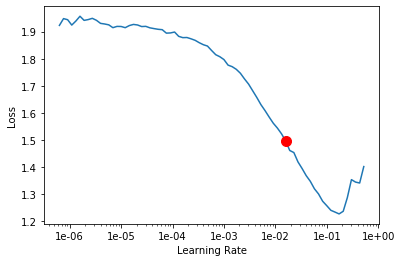

In [173]:
learn.recorder.plot(suggestion=True)

### Start to train

epoch,train_loss,valid_loss,accuracy,time
0,0.833422,0.366858,0.927406,00:07
1,0.474441,0.480209,0.905383,00:07
2,0.359525,0.269428,0.931485,00:07
3,0.256856,0.167082,0.941272,00:07
4,0.175991,0.138838,0.955954,00:07
5,0.127244,0.106663,0.960848,00:07


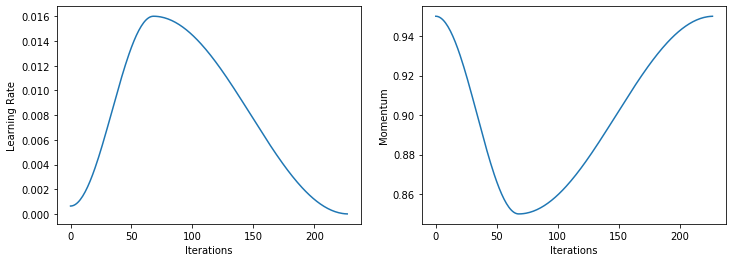

In [174]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(6, max_lr=1.6e-2)
learn.recorder.plot_lr(show_moms=True)

## Train on 5 Folds CV

In [19]:
image_root_dir = "/data2/datasets/clobotics/ccth/images/cropped/versions/train20200129_val20200117_test20191122/for-image-quality-model/round1"
cv_indices_dir = Path("/data2/datasets/clobotics/ccth/indices/versions/train20200129_val20200117_test20191122/round1-cv")
num_folds = 5
n_max_epochs = 2
batch_size = 64
tta = False


def read_train_val_indices(train_indices_path, val_indices_path):
    train_df = pd.read_csv(train_indices_path, header=None, sep=" ", names=["name", "label"])
    val_df = pd.read_csv(val_indices_path, header=None, sep=" ", names=["name", "label"])
    train_df['is_valid'] = False
    val_df['is_valid'] = True
    return pd.concat([train_df, val_df])

### Transforms

In [28]:
tfms = get_transforms(
    do_flip=True,  # default True
    flip_vert=False,  # default False
    max_rotate=15.0,  # default 10.0
    max_zoom=1.0,  # default 1.1
    max_lighting=0.2,  # default 0.2
    max_warp=0.2,  # default 0.2
    p_affine=0.75,  # default 0.75
    p_lighting=0.75,  # default 0.75
)

### Find LR

Loaded pretrained weights for efficientnet-b0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 4.79E-03


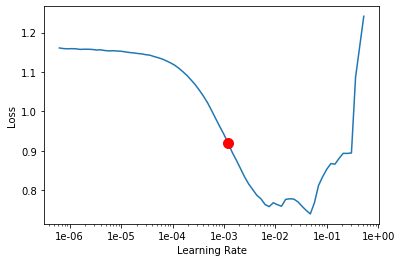

In [25]:
df = read_train_val_indices(
    cv_indices_dir / "0" / "train.txt",
    cv_indices_dir / "0" / "val.txt",
)

data = ImageList\
    .from_df(df, image_root_dir)\
    .split_from_df()\
    .label_from_df()\
    .transform(tfms, size=224, resize_method=ResizeMethod.PAD, padding_mode='zeros')\
    .databunch(bs=batch_size, num_workers=4) \
    .normalize(imagenet_stats)

# learn = cnn_learner(data, models.resnet50, metrics=accuracy)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)
learn = Learner(data, model, metrics=accuracy, path="/tmp/fastai-models")
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Start Training

__resnet18, bs=128, max_rotate=5, pad__

- max_lr=1e-3, 10 epochs: 0.91
- max_lr=3e-3,  8 epochs: 0.925
- max_lr=1e-2,  8 epochs: 0.87

__efficientnet-b0, bs=64, max_rotate=10, pad__

- max_lr=2e-4, 1 epoch: 
- max_lr=6e-4, 2 epoch:

__efficientnet-b0, bs=64, max_rotate=15, pad__

- max_lr=1.2e-3, 1 epoch: 91.4, 91.7, 90,   88,   93.1
- max_lr=1.2e-3, 2 epoch: 93.7, 94.1, 92.2, 88.1, 94.5
- max_lr=1.2e-3, 3 epoch: 85.3, 94.3, 91.3, 91.6, 95.6
- max_lr=6e-4,   2 epoch: 95.8, 93.5, 92.1, 91.0, 93.2
- max_lr=8e-4,   2 epoch: 90,   94.9, 92.4, 92.5, 94.9
- max_lr=9e-4,   2 epoch: 87.3, 93.6, 92.7, 89.4, 94
- max_lr=9e-4,   1 epoch: 92,   91.7, 89.6, 89.1, 92.1
- max_lr=9e-4,   2 epoch: 90,   94,   91.3, 91.9, 93.1



In [29]:
for fold in range(num_folds):
    data_fold = read_train_val_indices(
        cv_indices_dir / str(fold) / "train.txt",
        cv_indices_dir / str(fold) / "val.txt",
    )
    
    data = ImageList\
        .from_df(data_fold, image_root_dir)\
        .split_from_df()\
        .label_from_df()\
        .transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')\
        .databunch(bs=batch_size, num_workers=4) \
        .normalize(imagenet_stats)

#     learn = cnn_learner(data, models.resnet50, metrics=accuracy)
    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)
    learn = Learner(data, model, metrics=accuracy, path="/tmp/fastai-models")
    learn.fit_one_cycle(n_max_epochs, max_lr=6e-4)
    
    if tta:
        print(f"TTA accuracy: {accuracy(*learn.TTA(scale=1.0))}")

Loaded pretrained weights for efficientnet-b0


epoch,train_loss,valid_loss,accuracy,time
0,0.330431,0.247808,0.905460,00:28
1,0.143855,0.210599,0.937245,00:28


Loaded pretrained weights for efficientnet-b0


epoch,train_loss,valid_loss,accuracy,time
0,0.315749,0.429109,0.883456,00:28
1,0.132040,0.179310,0.929910,00:28


Loaded pretrained weights for efficientnet-b0


epoch,train_loss,valid_loss,accuracy,time
0,0.309843,0.695695,0.878566,00:28
1,0.139397,0.315885,0.900571,00:28


Loaded pretrained weights for efficientnet-b0


epoch,train_loss,valid_loss,accuracy,time
0,0.314775,0.454976,0.895681,00:28
1,0.140929,0.203393,0.934800,00:29


Loaded pretrained weights for efficientnet-b0


epoch,train_loss,valid_loss,accuracy,time
0,0.339448,0.301960,0.918434,00:29
1,0.148211,0.167297,0.939641,00:29


### Understand Errors

In [30]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [59]:
top_losses_index = interp.top_losses(k=50).indices.numpy()

In [82]:
print(f"preds: {preds[top_losses_index].argmax(dim=1)}")
print(f"   gt: {y[top_losses_index]}")

preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 1])
   gt: tensor([0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2])


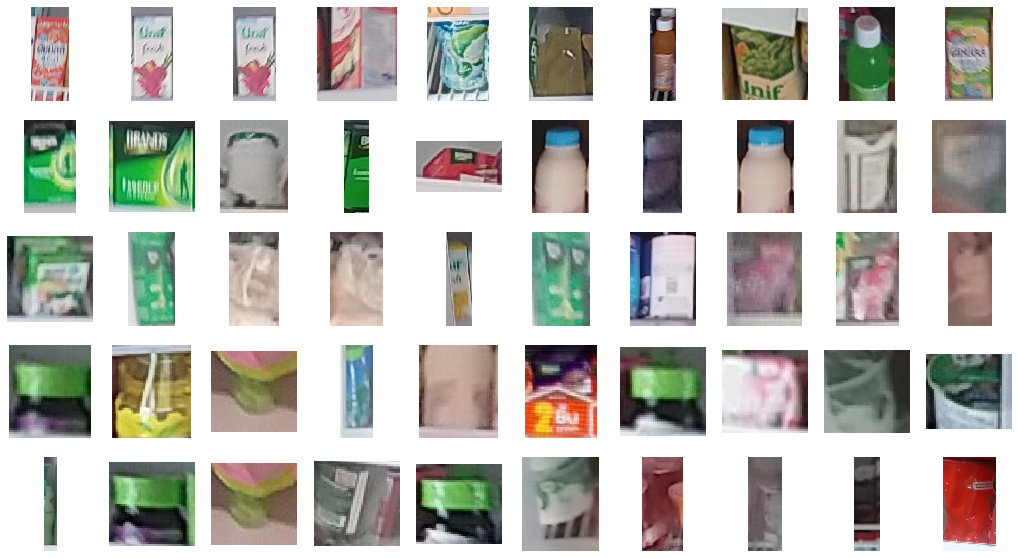

In [60]:
nrows, ncols = 5, 10
fig, ax = plt.subplots(5, 10, figsize=(18, 10))
for i, idx in enumerate(top_losses_index):
    data.valid_ds.x[idx].show(ax[i // ncols][i % ncols])

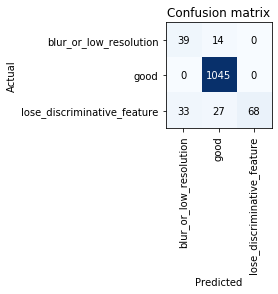

In [57]:
interp.plot_confusion_matrix()